In [1]:
import numpy as np
import scipy as sc

class xdes:
    
    def __init__(self,X):
        self.x=X
    
    
    def iden(self):
        return self.x
    
    def mon(self,N):
        x_mon=np.ones(self.x.shape[0])[:,None]
        for s in range(1,N+1):
            x_mon=np.hstack((x_mon,self.x**s))
        
        return x_mon
    
    def four(self,N):
        xfour=np.hstack((np.zeros(self.x.shape[0])[:,None],np.ones(self.x.shape[0])[:,None]))
        for s in range(1,N+1):
            xfour=np.hstack((xfour,np.hstack((np.sin(s*np.pi*self.x),np.cos(s*np.pi*self.x)))))
        
        return xfour
    
    def lege(self,N):
        w=sc.special.legendre(1)
        lege_2=w(self.x)
        lege_1=lege_2
        for s in range (2,N+1):
            w=sc.special.legendre(s)
            lege_2=w(self.x)
            lege_1=np.hstack((lege_1,lege_2))
        return lege_1

Text(0.5, 0, '$x$')

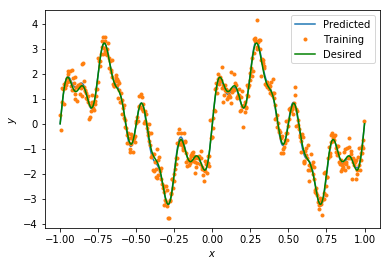

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 11 00:05:19 2019

@author: Neil Rodrigues
"""
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from pyDOE import lhs
#from basis_11 import xdes
import matplotlib.pyplot as plt
from random import choices


#parameters
d=16               # number of features
a=0.001             # alpha
b_1=0.9             # beta1
b_2=0.999           # beta2
e=10**-7            # epsilon
Nt=10000            # number of iterations
N=500               # number of data points
batch=500             #batchsize
los_1=[]

#generate N values of x, phi(x) and y from a latinhypercube
#x_1 is phi(x) which is the feature vector
def generate_x(N):
    x = 2*lhs(1,N)-1;                                                 
    y = np.array(2*np.sin(2*np.pi*x)+np.sin(8*np.pi*x)+0.5*np.sin(16*np.pi*x)) 
    x_four = xdes(x)
    x_1 = x_four.four(d);
    return x_1, y, x

#Generate a random initial weight and sigma matix
def generate_rand():
    weight = np.random.random_sample([2*d+2,1])
    sigma = np.random.random_sample([1,1])
   
    return weight, sigma

#Defining the negative loss function        
def neglog(w_1,sigma):      
    wTx=np.dot(x_1,w_1)
    loss_1=batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.dot((y-wTx).T,(y-wTx))  
    return loss_1

#Choosing random sets of values from phi_x and y
#randomweights is a appended matrix with phi_x and y
def batch_size():
    indices=choices(range(0,randomweights.shape[0]),k=batch)
    randomset=randomweights[indices]
    y=randomset[:,-1][:,None]
    x_1=randomset[:,0:randomset.shape[1]-1]
    return x_1, y


xmain, ymain, x =generate_x(500)
ymain=ymain+0.2*np.std(ymain)*np.random.randn(N,1)
randomweights=np.hstack((xmain,ymain))

#initialising all variables
w_1 , sigma = generate_rand()
m_w_1=np.zeros((2*d+2,1))
v_w_1=np.zeros((2*d+2,1))
m_sigma_1=0
v_sigma_1=0

#first derivative of loss function wrt weights
jacobian_w = jacobian(neglog,0)
#first derivative of loss function wrt standard deviation
jacobian_sigma = jacobian(neglog,1)


for t in range(1,Nt):
       #iteration number
       x_1 , y = batch_size()
       m_w_1 = b_1*m_w_1 + (1-b_1)*np.reshape(jacobian_w(w_1,sigma),(2*d+2,1))
       v_w_1 = b_2*v_w_1 + (1-b_2)*np.power(np.reshape(jacobian_w(w_1,sigma),(2*d+2,1)),2)

    
       m_w_t=m_w_1/(1-np.power(b_1,t))
       v_w_t=v_w_1/(1-np.power(b_2,t))
       
       m_sigma_1 = b_1*m_sigma_1 + (1-b_1)*np.reshape(jacobian_sigma(w_1,sigma),(1,1))
       v_sigma_1 = b_2*v_sigma_1 + (1-b_2)*np.power(np.reshape(jacobian_sigma(w_1,sigma),(1,1)),2)
            
       m_sigma_t=m_sigma_1/(1-np.power(b_1,t))
       v_sigma_t=v_sigma_1/(1-np.power(b_2,t))
       
       sigma = sigma - a*np.divide(m_sigma_t,np.sqrt(v_sigma_t)+e)
       w_1 = w_1 - a*np.divide(m_w_t,np.sqrt(v_w_t)+e)
       los= batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.matmul((ymain-np.matmul(xmain,w_1)).T,(ymain-np.matmul(xmain,w_1))) 
       los_1 = np.append(los_1,los)

x_test=np.array(np.linspace(-1,1,300))[:,None]
y2 = np.array(2*np.sin(2*np.pi*x_test)+np.sin(8*np.pi*x_test)+0.5*np.sin(16*np.pi*x_test)) 
x_four = xdes(x_test)
x_1 = x_four.four(d);
#evaluating the function where y is the estimated y
y=np.matmul(x_1,w_1);
los= N*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.matmul((ymain-np.matmul(xmain,w_1)).T,(ymain-np.matmul(xmain,w_1))) 
los_1 = np.append(los_1,los)
plt.plot(x_test,y,label='Predicted')
plt.plot(x,ymain,'.',label='Training')
plt.plot(x_test,y2,'g',label='Desired')
plt.legend()
plt.ylabel('$y$')
plt.xlabel('$x$')
#plt.plot(los_1)

Text(0, 0.5, '$Loss$')

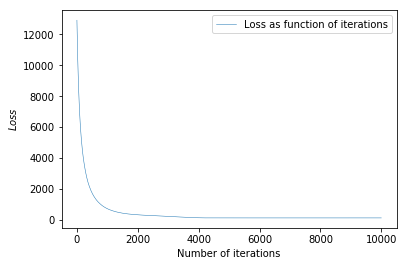

In [8]:
plt.plot(los_1,linewidth=0.5,label='Loss as function of iterations')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('$Loss$')

Text(0.5, 0, '$x$')

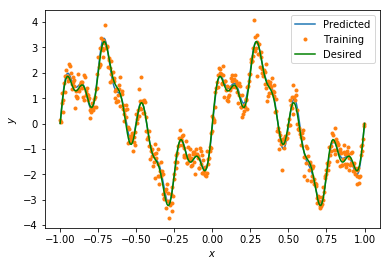

In [9]:
#Batch size 1
"""
Created on Mon Feb 11 00:05:19 2019

@author: Neil Rodrigues
"""
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from pyDOE import lhs
#from basis_11 import xdes
import matplotlib.pyplot as plt
from random import choices


#parameters
d=16                # number of features
a=0.001             # alpha
b_1=0.9             # beta1
b_2=0.999           # beta2
e=10**-7            # epsilon
Nt=10000            # number of iterations
N=500               # number of data points
batch=1             #batchsize
los_1=[]

#generate N values of x, phi(x) and y from a latinhypercube
#x_1 is phi(x) which is the feature vector
def generate_x(N):
    x = 2*lhs(1,N)-1;                                                 
    y = np.array(2*np.sin(2*np.pi*x)+np.sin(8*np.pi*x)+0.5*np.sin(16*np.pi*x)) 
    x_four = xdes(x)
    x_1 = x_four.four(d);
    return x_1, y, x

#Generate a random initial weight and sigma matix
def generate_rand():
    weight = np.random.random_sample([2*d+2,1])
    sigma = np.random.random_sample([1,1])
   
    return weight, sigma

#Defining the negative loss function        
def neglog(w_1,sigma):      
    wTx=np.dot(x_1,w_1)
    loss_1=batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.dot((y-wTx).T,(y-wTx))  
    return loss_1

#Choosing random sets of values from phi_x and y
#randomweights is a appended matrix with phi_x and y
def batch_size():
    indices=choices(range(0,randomweights.shape[0]),k=batch)
    randomset=randomweights[indices]
    y=randomset[:,-1][:,None]
    x_1=randomset[:,0:randomset.shape[1]-1]
    return x_1, y


xmain, ymain, x =generate_x(500)
ymain=ymain+0.2*np.std(ymain)*np.random.randn(N,1)
randomweights=np.hstack((xmain,ymain))

#initialising all variables
w_1 , sigma = generate_rand()
m_w_1=np.zeros((2*d+2,1))
v_w_1=np.zeros((2*d+2,1))
m_sigma_1=0
v_sigma_1=0

#first derivative of loss function wrt weights
jacobian_w = jacobian(neglog,0)
#first derivative of loss function wrt standard deviation
jacobian_sigma = jacobian(neglog,1)


for t in range(1,Nt):
       #iteration number
       x_1 , y = batch_size()
       m_w_1 = b_1*m_w_1 + (1-b_1)*np.reshape(jacobian_w(w_1,sigma),(2*d+2,1))
       v_w_1 = b_2*v_w_1 + (1-b_2)*np.power(np.reshape(jacobian_w(w_1,sigma),(2*d+2,1)),2)

    
       m_w_t=m_w_1/(1-np.power(b_1,t))
       v_w_t=v_w_1/(1-np.power(b_2,t))
       
       m_sigma_1 = b_1*m_sigma_1 + (1-b_1)*np.reshape(jacobian_sigma(w_1,sigma),(1,1))
       v_sigma_1 = b_2*v_sigma_1 + (1-b_2)*np.power(np.reshape(jacobian_sigma(w_1,sigma),(1,1)),2)
            
       m_sigma_t=m_sigma_1/(1-np.power(b_1,t))
       v_sigma_t=v_sigma_1/(1-np.power(b_2,t))
       
       sigma = sigma - a*np.divide(m_sigma_t,np.sqrt(v_sigma_t)+e)
       w_1 = w_1 - a*np.divide(m_w_t,np.sqrt(v_w_t)+e)
       los= batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.matmul((ymain-np.matmul(xmain,w_1)).T,(ymain-np.matmul(xmain,w_1))) 
       los_1 = np.append(los_1,los)

x_test=np.array(np.linspace(-1,1,300))[:,None]
y2 = np.array(2*np.sin(2*np.pi*x_test)+np.sin(8*np.pi*x_test)+0.5*np.sin(16*np.pi*x_test)) 
x_four = xdes(x_test)
x_1 = x_four.four(d);
#evaluating the function where y is the estimated y
y=np.matmul(x_1,w_1);

plt.plot(x_test,y,label='Predicted')
plt.plot(x,ymain,'.',label='Training')
plt.plot(x_test,y2,'g',label='Desired')
plt.legend()
plt.ylabel('$y$')
plt.xlabel('$x$')
#plt.plot(los_1)

Text(0, 0.5, '$Loss$')

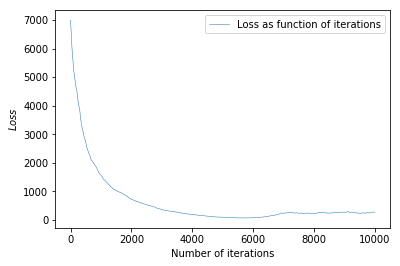

In [10]:
plt.plot(los_1,linewidth=0.5,label='Loss as function of iterations')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('$Loss$')#batch size 1

Text(0.5, 0, '$x$')

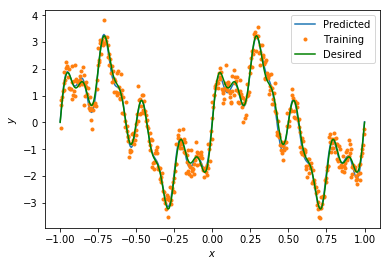

In [15]:
# batch size 64
"""
Created on Mon Feb 11 00:05:19 2019

@author: Neil Rodrigues
"""
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from pyDOE import lhs
#from basis_11 import xdes
import matplotlib.pyplot as plt
from random import choices


#parameters
d=16                # number of features
a=0.001             # alpha
b_1=0.9             # beta1
b_2=0.999           # beta2
e=10**-7            # epsilon
Nt=10000            # number of iterations
N=500               # number of data points
batch=64            #batchsize
los_1=[]

#generate N values of x, phi(x) and y from a latinhypercube
#x_1 is phi(x) which is the feature vector
def generate_x(N):
    x = 2*lhs(1,N)-1;                                                 
    y = np.array(2*np.sin(2*np.pi*x)+np.sin(8*np.pi*x)+0.5*np.sin(16*np.pi*x)) 
    x_four = xdes(x)
    x_1 = x_four.four(d);
    return x_1, y, x

#Generate a random initial weight and sigma matix
def generate_rand():
    weight = np.random.random_sample([2*d+2,1])
    sigma = np.random.random_sample([1,1])
   
    return weight, sigma

#Defining the negative loss function        
def neglog(w_1,sigma):      
    wTx=np.dot(x_1,w_1)
    loss_1=batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.dot((y-wTx).T,(y-wTx))  
    return loss_1

#Choosing random sets of values from phi_x and y
#randomweights is a appended matrix with phi_x and y
def batch_size():
    indices=choices(range(0,randomweights.shape[0]),k=batch)
    randomset=randomweights[indices]
    y=randomset[:,-1][:,None]
    x_1=randomset[:,0:randomset.shape[1]-1]
    return x_1, y


xmain, ymain, x =generate_x(500)
ymain=ymain+0.2*np.std(ymain)*np.random.randn(N,1)
randomweights=np.hstack((xmain,ymain))

#initialising all variables
w_1 , sigma = generate_rand()
m_w_1=np.zeros((2*d+2,1))
v_w_1=np.zeros((2*d+2,1))
m_sigma_1=0
v_sigma_1=0

#first derivative of loss function wrt weights
jacobian_w = jacobian(neglog,0)
#first derivative of loss function wrt standard deviation
jacobian_sigma = jacobian(neglog,1)


for t in range(1,Nt):
       #iteration number
       x_1 , y = batch_size()
       m_w_1 = b_1*m_w_1 + (1-b_1)*np.reshape(jacobian_w(w_1,sigma),(2*d+2,1))
       v_w_1 = b_2*v_w_1 + (1-b_2)*np.power(np.reshape(jacobian_w(w_1,sigma),(2*d+2,1)),2)

    
       m_w_t=m_w_1/(1-np.power(b_1,t))
       v_w_t=v_w_1/(1-np.power(b_2,t))
       
       m_sigma_1 = b_1*m_sigma_1 + (1-b_1)*np.reshape(jacobian_sigma(w_1,sigma),(1,1))
       v_sigma_1 = b_2*v_sigma_1 + (1-b_2)*np.power(np.reshape(jacobian_sigma(w_1,sigma),(1,1)),2)
            
       m_sigma_t=m_sigma_1/(1-np.power(b_1,t))
       v_sigma_t=v_sigma_1/(1-np.power(b_2,t))
       
       sigma = sigma - a*np.divide(m_sigma_t,np.sqrt(v_sigma_t)+e)
       w_1 = w_1 - a*np.divide(m_w_t,np.sqrt(v_w_t)+e)
       los= batch*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.matmul((ymain-np.matmul(xmain,w_1)).T,(ymain-np.matmul(xmain,w_1))) 
       los_1 = np.append(los_1,los)

x_test=np.array(np.linspace(-1,1,300))[:,None]
y2 = np.array(2*np.sin(2*np.pi*x_test)+np.sin(8*np.pi*x_test)+0.5*np.sin(16*np.pi*x_test)) 
x_four = xdes(x_test)
x_1 = x_four.four(d);
#evaluating the function where y is the estimated y
y=np.matmul(x_1,w_1);
los= N*np.log(2*np.pi*sigma*sigma)/2+(1/(2*sigma*sigma))*np.matmul((ymain-np.matmul(xmain,w_1)).T,(ymain-np.matmul(xmain,w_1))) 
los_1 = np.append(los_1,los)
plt.plot(x_test,y,label='Predicted')
plt.plot(x,ymain,'.',label='Training')
plt.plot(x_test,y2,'g',label='Desired')
plt.legend()
plt.ylabel('$y$')
plt.xlabel('$x$')
#plt.plot(los_1)


Text(0, 0.5, '$Loss$')

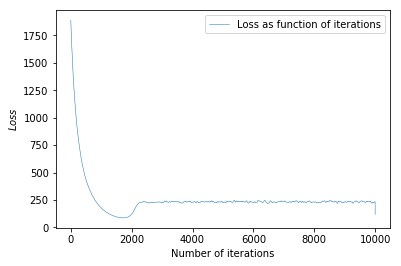

In [16]:
plt.plot(los_1,linewidth=0.5,label='Loss as function of iterations')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('$Loss$') #batch size 64